# Creating a Time Series Forecast in Python

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

Sources:
http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

### Imports Python Libraries

In [881]:
# imports

import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras

# jupyter command - allows plots to show up
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from datetime import datetime

### Assigns a Seed to Ensure reproducable results

In [882]:
# fixes the random number seed to ensure reproducible results
np.random.seed(69)

### Imports a csv data set using Panda

In [883]:
# load the dataset
#dataframe = pd.read_csv('ignored_assets/AirPassengers.csv', usecols=[1], engine='python', skipfooter=3)
#dataset = dataframe.values
#dataset = dataset.astype('float32')


# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '15min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=300)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)


# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset = dataframe.values
dataset = dataset.astype('float32')

### LSTM-RNN is sensitive to large numbers, so normalizing is a good idea

In [884]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

### Splits the data into training (first 2/3) and test sets (last 1/3)

In [885]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(67, 34)


### This fn takes two args and returns two datasets: 

A numpy array to be converted into a dataset, and the look_back (default to 1) which his the number of previous values used to predict the next value.


In [886]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

### Uses the Above Function to Create the Training and Test sets

In [887]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

### The Data Sets are in the Form [samples] [features] so We Reshape to be [samples, time-steps, features]

<b>Samples</b>: Each incident
<br/>
<b>Time Steps</b>: The observations that led up to the incident
<br/>
<b>Features</b>: The variables (or the data) observed

In [888]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [889]:
trainX[0,0,2]

0.68727416

### Uses the LSTM RNN from the Keras Library to Train a Neural Network with the Training Set


In [890]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1s - loss: 0.0419
Epoch 2/100
0s - loss: 0.0154
Epoch 3/100
0s - loss: 0.0113
Epoch 4/100
0s - loss: 0.0100
Epoch 5/100
0s - loss: 0.0090
Epoch 6/100
0s - loss: 0.0083
Epoch 7/100
0s - loss: 0.0078
Epoch 8/100
0s - loss: 0.0076
Epoch 9/100
0s - loss: 0.0074
Epoch 10/100
0s - loss: 0.0071
Epoch 11/100
0s - loss: 0.0069
Epoch 12/100
0s - loss: 0.0069
Epoch 13/100
0s - loss: 0.0068
Epoch 14/100
0s - loss: 0.0067
Epoch 15/100
0s - loss: 0.0066
Epoch 16/100
0s - loss: 0.0066
Epoch 17/100
0s - loss: 0.0066
Epoch 18/100
0s - loss: 0.0064
Epoch 19/100
0s - loss: 0.0063
Epoch 20/100
0s - loss: 0.0065
Epoch 21/100
0s - loss: 0.0062
Epoch 22/100
0s - loss: 0.0061
Epoch 23/100
0s - loss: 0.0062
Epoch 24/100
0s - loss: 0.0062
Epoch 25/100
0s - loss: 0.0061
Epoch 26/100
0s - loss: 0.0058
Epoch 27/100
0s - loss: 0.0058
Epoch 28/100
0s - loss: 0.0057
Epoch 29/100
0s - loss: 0.0058
Epoch 30/100
0s - loss: 0.0057
Epoch 31/100
0s - loss: 0.0056
Epoch 32/100
0s - loss: 0.0055
Epoch 33/100
0s -

In [891]:
model.predict(np.array([[[0,1,0.5]]]))

array([[ 0.50177026]], dtype=float32)

### With the Model Trained Above, We Have the Model Attempt to Generate the Last Third

In [892]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 247.43 RMSE
Test Score: 228.23 RMSE


1.125

In [896]:
trainPredict[:,0]

array([ 3502.73901367,  3265.51806641,  2999.41040039,  2652.54052734,
        2510.86474609,  2095.2578125 ,  1767.23364258,  1463.87414551,
        1176.81066895,   961.46044922,   822.64227295,   665.95733643,
         572.02813721,   453.33850098,   409.04486084,   367.29415894,
         338.2951355 ,   295.66757202,   258.53250122,   232.40844727,
         217.27261353,   223.25862122,   240.4019165 ,   273.72247314,
         430.91903687,   596.98077393,   798.28118896,  1134.51989746,
        1449.32104492,  1852.92333984,  2031.94226074,  2352.84814453,
        2575.30908203,  2778.55249023,  2733.90771484,  2832.31982422,
        2859.27075195,  2739.12304688,  2788.83813477,  2771.83422852,
        2835.54467773,  2867.97070312,  2939.11352539,  2913.43261719,
        3007.92553711,  3128.74731445,  3158.37182617,  3256.03955078,
        3285.94970703,  3302.48266602,  3356.64355469,  3450.35839844,
        3411.76635742,  3507.95556641,  3417.04394531,  3490.43994141,
      

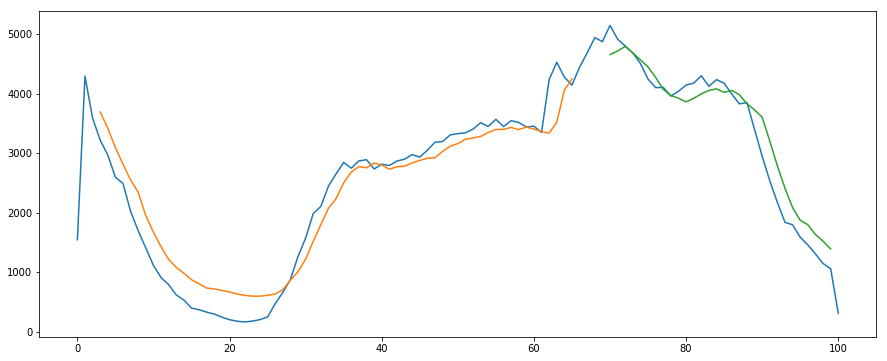

In [407]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<h1 style="font-size:3em; text-align: center">Making The LSTM-RNN Fit The Original Data</h1>

At first, I renamed many of the variables from the above to distinguish between the separate cases. However, I decided it more efficient to generalize the LSTM-RNN into a function for simpification

## Again With The Seeding for Reproducable Results

In [6]:
np.random.seed(69)

## Loads the Original Data Set, and Prepares them for the Neural Network

In [203]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '15min'

# load the dataset
car_dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=2000)
car_dataframe['time_bucket'] = pd.to_datetime(car_dataframe['time_bucket'])
car_dataframe = car_dataframe.set_index('time_bucket')
car_dataframe['total'] = car_dataframe.sum(axis=1)
car_dataframe['day_hour'] = car_dataframe.index.round(time_grouping)

# datasets for two districts in particular
car_dataframe_station_1 = car_dataframe[['1afd7afbc81ecc1b13886a569d869e8a', 'day_hour']].groupby('day_hour').sum();
car_dataset_station_1 = car_dataframe_station_1.values
car_dataset_station_1 = car_dataset_station_1.astype('float32')

car_dataframe_station_2 = car_dataframe[['d4ec2125aff74eded207d2d915ef682f', 'day_hour']].groupby('day_hour').sum();
car_dataset_station_2 = car_dataframe_station_2.values
car_dataset_station_2 = car_dataset_station_2.astype('float32')

# The data set with the sum of all the cars out at the 
car_dataframe = car_dataframe[['total','day_hour']].groupby('day_hour').sum()

car_dataset = car_dataframe.values
car_dataset = car_dataset.astype('float32')

In [204]:
car_dataset

array([[ 1549.],
       [ 4299.],
       [ 3591.],
       [ 3224.],
       [ 2971.],
       [ 2599.],
       [ 2494.],
       [ 2024.],
       [ 1697.],
       [ 1408.],
       [ 1117.],
       [  913.],
       [  794.],
       [  621.],
       [  535.],
       [  400.],
       [  372.],
       [  332.],
       [  300.],
       [  247.],
       [  205.],
       [  180.],
       [  167.],
       [  182.],
       [  207.],
       [  251.],
       [  474.],
       [  663.],
       [  881.],
       [ 1269.],
       [ 1577.],
       [ 1990.],
       [ 2109.],
       [ 2450.],
       [ 2655.],
       [ 2847.],
       [ 2751.],
       [ 2873.],
       [ 2894.],
       [ 2737.],
       [ 2819.],
       [ 2796.],
       [ 2872.],
       [ 2902.],
       [ 2980.],
       [ 2936.],
       [ 3053.],
       [ 3187.],
       [ 3199.],
       [ 3310.],
       [ 3332.],
       [ 3344.],
       [ 3408.],
       [ 3515.],
       [ 3452.],
       [ 3573.],
       [ 3450.],
       [ 3549.],
       [ 3521.

## Generalized the Above Described Process to Work With Most Datasets

In [355]:
def trainAndPredict(dataset, look_back=1, num_epochs=100):
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    print(len(train), len(test))

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=num_epochs, batch_size=1, verbose=2)
    
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    
    return model


(446, 221)
Epoch 1/10
1s - loss: 0.0223
Epoch 2/10
0s - loss: 0.0103
Epoch 3/10
0s - loss: 0.0068
Epoch 4/10
0s - loss: 0.0052
Epoch 5/10
0s - loss: 0.0045
Epoch 6/10
0s - loss: 0.0042
Epoch 7/10
0s - loss: 0.0038
Epoch 8/10
0s - loss: 0.0036
Epoch 9/10
0s - loss: 0.0035
Epoch 10/10
0s - loss: 0.0034
Train Score: 24.06 RMSE
Test Score: 34.10 RMSE


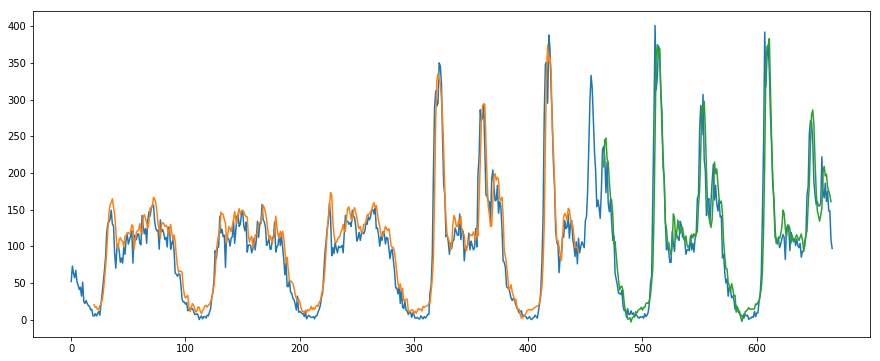

In [29]:
trainAndPredict(car_dataset_station_1, look_back=20, num_epochs=10)

(446, 221)
Epoch 1/100
1s - loss: 0.0221
Epoch 2/100
0s - loss: 0.0036
Epoch 3/100
0s - loss: 0.0028
Epoch 4/100
0s - loss: 0.0026
Epoch 5/100
0s - loss: 0.0022
Epoch 6/100
0s - loss: 0.0021
Epoch 7/100
0s - loss: 0.0019
Epoch 8/100
0s - loss: 0.0018
Epoch 9/100
0s - loss: 0.0017
Epoch 10/100
0s - loss: 0.0016
Epoch 11/100
0s - loss: 0.0016
Epoch 12/100
0s - loss: 0.0016
Epoch 13/100
0s - loss: 0.0015
Epoch 14/100
0s - loss: 0.0015
Epoch 15/100
0s - loss: 0.0015
Epoch 16/100
0s - loss: 0.0015
Epoch 17/100
0s - loss: 0.0014
Epoch 18/100
0s - loss: 0.0015
Epoch 19/100
0s - loss: 0.0015
Epoch 20/100
0s - loss: 0.0014
Epoch 21/100
0s - loss: 0.0014
Epoch 22/100
0s - loss: 0.0014
Epoch 23/100
0s - loss: 0.0014
Epoch 24/100
0s - loss: 0.0015
Epoch 25/100
0s - loss: 0.0014
Epoch 26/100
0s - loss: 0.0014
Epoch 27/100
0s - loss: 0.0014
Epoch 28/100
0s - loss: 0.0014
Epoch 29/100
0s - loss: 0.0014
Epoch 30/100
0s - loss: 0.0014
Epoch 31/100
0s - loss: 0.0013
Epoch 32/100
0s - loss: 0.0014
Epoch 

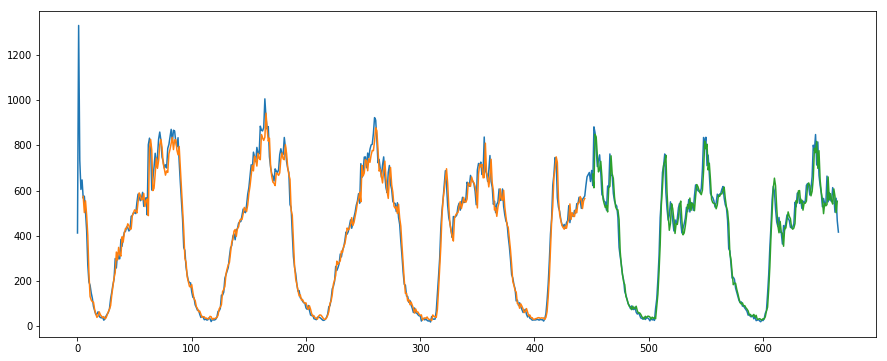

In [30]:
trainAndPredict(car_dataset_station_2, look_back=5)

(446, 221)
Epoch 1/5
1s - loss: 0.0327
Epoch 2/5
0s - loss: 0.0127
Epoch 3/5
0s - loss: 0.0076
Epoch 4/5
0s - loss: 0.0051
Epoch 5/5
0s - loss: 0.0035
Train Score: 383.89 RMSE
Test Score: 546.23 RMSE


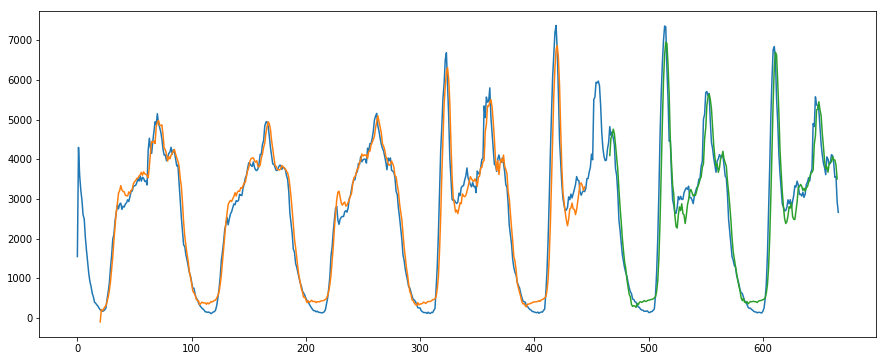

In [377]:
np.random.seed(69)
training_model = trainAndPredict(car_dataset, look_back=20, num_epochs=5)

# The Prediction Function

This function, given a keras LSTM Model that has been already trained, and data to feed the model, will return a 1-D array with the predicted values for the next 2 hours

<b>@param</b> <i>model</i> - The Keras Model that has been previously trained 
<br/>
<b>@param</b> <i>data</i> - A 2-D NumPy Array with data for the previous times in the first row
<br/>
<b>@param</b> <i>time_group</i> (opt) - the time grouping for the valies (default to the global variable for time_grouping)
<br/>
<br/>
<b>@returns</b> - 1-D array for the expected next two hours

In [416]:
def predictNext2Hours (model, dataset, time_group=time_grouping):
    dataset.astype('float32')
    predictions = []
    
    # for as many times as it takes until the number of predictions x time_group >= 2 hours
    for i in range(20):
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = dataset.transpose()
        dataset = scaler.fit_transform(dataset)
        dataset = dataset.transpose()
        
        # reshape the dataset
        data = dataset.T
        data = data.reshape(1, 1, data.shape[0])
        
        # make a prediction
        prediction = model.predict(data)
        
        # take out the first element, add the prediction to the end
        dataset[0][0:len(dataset[0])-1] = dataset[0][ 1: len(dataset[0])]
        dataset[0, len(dataset[0])-1] = prediction
        
        # un-normalize the data set
        dataset = dataset.transpose()
        dataset = scaler.inverse_transform(dataset)
        dataset = dataset.transpose()
        # push the prediction into the array of predictions
        predictions.append(dataset[0, len(dataset[0])-1])
        
        # repeat
    
    return predictions

In [418]:
pred = predictNext2Hours (training_model, np.array([[2494,2024,1697,1408,1117,913,794,621,535,400,372,332,300,247,180,167,182,207,251,474]]))
pred

[222.98252649046481,
 205.51665758155286,
 274.44405679404736,
 253.9148350507021,
 227.96705198287961,
 213.87275378406042,
 282.25949029624462,
 237.08865919709206,
 230.76347041130066,
 250.84773507714272,
 247.96411865949631,
 265.23679554462433,
 203.25576522201297,
 260.28729170560837,
 291.59932401776314,
 230.28993332386014,
 254.20749223232269,
 269.93946023311423,
 254.17511333899819,
 257.68590369865706]

In [385]:
actu = np.array([[  663.],
[  881.],
[ 1269.],
[ 1577.],
[ 1990.],
[ 2109.],
[ 2450.],
[ 2655.],
[ 2847.],
[ 2751.],
[ 2873.],
[ 2894.],
[ 2737.],
[ 2819.],
[ 2796.],
[ 2872.],
[ 2902.],
[ 2980.],
[ 2936.],
[ 3053.],
])

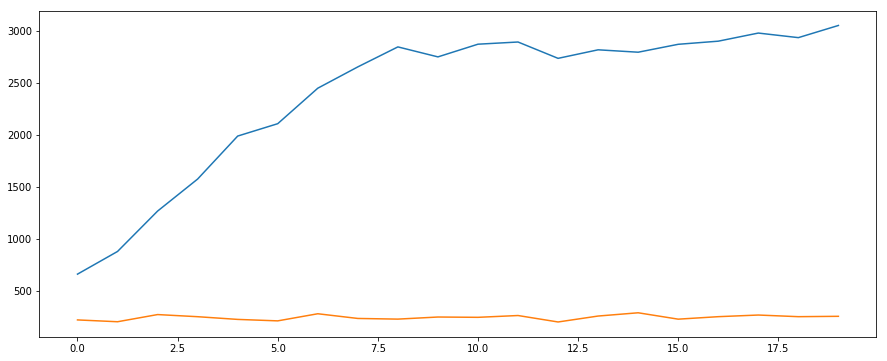

In [388]:
plt.plot(actu[:,0])
plt.plot(pred)

In [437]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
1s - loss: 0.0560
Epoch 2/10
0s - loss: 0.0205
Epoch 3/10
0s - loss: 0.0122
Epoch 4/10
0s - loss: 0.0101
Epoch 5/10
0s - loss: 0.0087
Epoch 6/10
0s - loss: 0.0077
Epoch 7/10
0s - loss: 0.0069
Epoch 8/10
0s - loss: 0.0063
Epoch 9/10
0s - loss: 0.0060
Epoch 10/10
0s - loss: 0.0058


In [435]:
trainY

array([ 0.61360896,  0.56282616,  0.48815736,  0.46708152,  0.37274188,
        0.30710557,  0.24909675,  0.19068648,  0.14973907,  0.12585308,
        0.09112807,  0.07386592,  0.04676836,  0.04114814,  0.03311923,
        0.02669611,  0.01605781,  0.00762746,  0.00260939,  0.        ,
        0.00301084,  0.00802891,  0.0168607 ,  0.06162184,  0.09955841,
        0.14331594,  0.22119632,  0.28301886,  0.3659173 ,  0.38980329,
        0.45824969,  0.49939784,  0.53793657,  0.51866716,  0.54315531,
        0.54737049,  0.51585704,  0.53231633,  0.52769971,  0.54295462,
        0.5489763 ,  0.56463265,  0.55580086,  0.57928538,  0.60618222,
        0.6085909 ,  0.63087112,  0.63528699,  0.63769567,  0.6505419 ,
        0.67201924,  0.6593737 ,  0.68366116,  0.65897226,  0.6788438 ,
        0.67322356,  0.6575672 ,  0.66017663,  0.63930148,  0.81714165,
        0.87595338,  0.82597345,  0.79887593], dtype=float32)

# Making LSTM w/ Multiple Outputs

In [878]:
# imports

import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras

# jupyter command - allows plots to show up
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from datetime import datetime

In [879]:
# fixes the random number seed to ensure reproducible results
np.random.seed(69)

In [880]:

# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5000)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)


# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset = dataframe.values
dataset = dataset.astype('float32')

In [833]:
look_forward = 24

In [834]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [835]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset)-look_forward,:]
print(len(train), len(test))

(3350, 1626)


In [836]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)

In [837]:
# reshape into X=t and Y=t+1
look_back = 288
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)


In [838]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [839]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(look_forward))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
7s - loss: 0.0243
Epoch 2/5
5s - loss: 0.0114
Epoch 3/5
5s - loss: 0.0084
Epoch 4/5
6s - loss: 0.0075
Epoch 5/5
5s - loss: 0.0071


In [850]:
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
5s - loss: 0.0046
Epoch 1/1
5s - loss: 0.0046
Epoch 1/1
5s - loss: 0.0045
Epoch 1/1
5s - loss: 0.0045


In [841]:
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
5s - loss: 0.0057
Epoch 1/1
5s - loss: 0.0055
Epoch 1/1
5s - loss: 0.0055
Epoch 1/1
5s - loss: 0.0054
Epoch 1/1
5s - loss: 0.0052
Epoch 1/1
5s - loss: 0.0052
Epoch 1/1
5s - loss: 0.0051
Epoch 1/1
5s - loss: 0.0050
Epoch 1/1
5s - loss: 0.0050
Epoch 1/1
5s - loss: 0.0049
Epoch 1/1
6s - loss: 0.0048
Epoch 1/1
5s - loss: 0.0047


In [842]:
def predictNext2Hours (model, dataset):
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    dataset = dataset.transpose()
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
        
    # reshape the dataset
    data = dataset.T
    data = data.reshape(1, 1, data.shape[0])
        
    # make a prediction
    prediction = model.predict(data)
    

    # un-normalize the data set
    prediction = scaler.inverse_transform(prediction)
    
    return prediction

# 15 minutes
pred = predictNext2Hours (model, np.array([[2494,2024,1697,1408,1117,913,794,621,535,400,372,332,300,247,180,167,182,207,251,474]]))
pred

In [877]:
pred = predictNext2Hours(model, car_dataset[0:288].reshape(288))
pred

/home/rdit/development/ts-predict/venv/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/rdit/development/ts-predict/venv/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([[ 2725.56591797,  2714.93823242,  2696.35961914,  2663.9543457 ,
         2612.45263672,  2562.69018555,  2523.07226562,  2494.94677734,
         2488.56225586,  2423.8215332 ,  2381.31347656,  2364.65185547,
         2307.3996582 ,  2278.21655273,  2270.65942383,  2216.48242188,
         2181.98486328,  2142.55566406,  2115.70678711,  2101.04492188,
         2076.09204102,  2047.09411621,  2012.20202637,  1998.65283203]], dtype=float32)

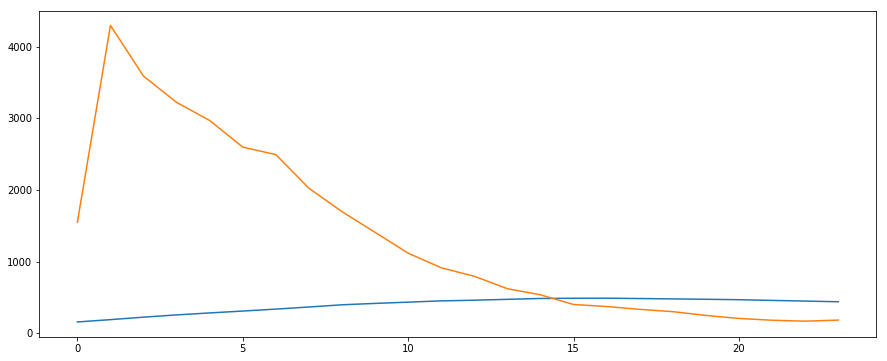

In [873]:
plt.plot(pred[0])
plt.plot(car_dataset[0:24])

In [853]:
pred = predictNext2Hours(model, np.array([
       [  788.],       [  710.],       [  677.],       [  637.],       [  585.],       [  567.],       [  545.],       [  501.],       [  484.],       [  423.],       [  402.],       [  354.],       [  361.],       [  309.],       [  317.],       [  287.],       [  288.],       [  283.],       [  223.],       [  216.],       [  202.],       [  203.],       [  176.],       [  176.],       [  183.],       [  139.],       [  120.],       [  141.],       [  133.],       [  122.],       [  117.],       [  109.],       [  105.],       [  118.],       [   99.],       [  111.],       [   90.],       [   79.],       [   86.],       [   82.],       [   67.],       [   74.],       [   64.],       [   61.],       [   57.],       [   62.],       [   52.],       [   54.],       [   61.],       [   66.],       [   62.],       [   54.],       [   74.],       [   69.],       [   64.],       [   63.],       [   86.],       [  102.],       [  102.],       [  202.]]).reshape(1,60))
pred

array([[ 155.83947754,  188.66775513,  223.20219421,  254.71896362,
         282.17633057,  308.52853394,  335.75183105,  365.04696655,
         395.94570923,  415.24838257,  432.94281006,  450.59329224,
         459.96209717,  472.38528442,  484.30532837,  487.1394043 ,
         488.10217285,  483.40240479,  478.16268921,  473.23248291,
         466.8611145 ,  457.34649658,  447.94717407,  438.33764648]], dtype=float32)

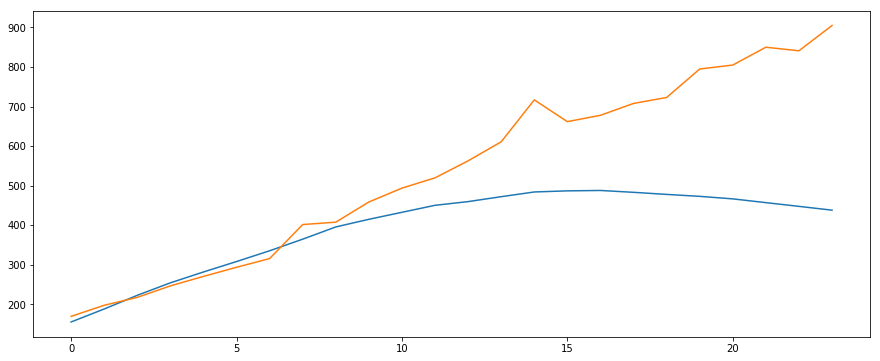

In [854]:
plt.plot(pred[0])
plt.plot(np.array([
       [  170.],
       [  198.],
       [  218.],
       [  247.],
       [  271.],
       [  294.],
       [  316.],
       [  402.],
       [  408.],
       [  459.],
       [  494.],
       [  520.],
       [  563.],
       [  611.],
       [  717.],
       [  662.],
       [  678.],
       [  708.],
       [  723.],
       [  795.],
       [  805.],
       [  850.],
       [  841.],
       [  905.]
]).reshape(24))

## Overall Data

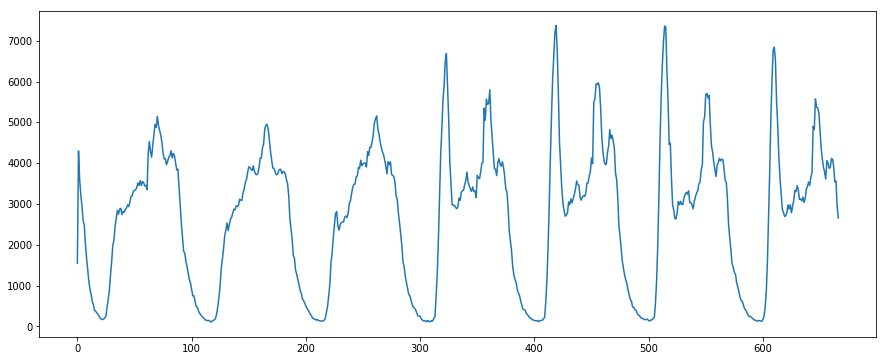

In [871]:

plt.plot(car_dataset[0:5000])

In [868]:
car_dataset[0:20]

array([[ 1549.],
       [ 4299.],
       [ 3591.],
       [ 3224.],
       [ 2971.],
       [ 2599.],
       [ 2494.],
       [ 2024.],
       [ 1697.],
       [ 1408.],
       [ 1117.],
       [  913.],
       [  794.],
       [  621.],
       [  535.],
       [  400.],
       [  372.],
       [  332.],
       [  300.],
       [  247.]], dtype=float32)